In [85]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
from datetime import date, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN

In [86]:
#setting a random set
tf.random.set_seed(1234)

In [87]:
# #selecting a country
# country = 'India'

In [88]:
# #Total COVID deaths cases
# df_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
# #df_deaths.to_csv('global.csv')
# df_deaths_country = df_deaths[df_deaths["Country/Region"] == country]
# df_deaths_country = pd.DataFrame(df_deaths_country[df_deaths_country.columns[4:]].sum(),columns=["deaths"])
# df_deaths_country.index = pd.to_datetime(df_deaths_country.index,format='%m/%d/%y')
# df_deaths_country.index.name = 'date'

In [89]:
# df_deaths_country[:830]

In [90]:
# #Total daily cases
# daily_death=pd.DataFrame()
# daily_death['death'] = df_deaths_country["deaths"].diff().fillna(0).astype('int64')

In [91]:
# daily_death = daily_death[:830]
# daily_death

In [92]:
# daily_death.to_csv('daily_death.csv')

In [93]:
#reading the dataset
daily_death = pd.read_csv('daily_death.csv')
daily_death.set_index('date',inplace = True)
daily_death.index=pd.to_datetime(daily_death.index)
daily_death

,death
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2022-04-26,1431
2022-04-27,39
2022-04-28,60


In [94]:
daily_death.describe()

,death
count,830.000000
mean,631.136145
std,906.799480
min,-1.000000
25%,125.250000
50%,354.500000
75%,689.500000
max,7374.000000


In [95]:
print(daily_death.skew())
print(daily_death.kurt())
print(daily_death.median())

death    2.920922
dtype: float64
death    9.563424
dtype: float64
death    354.5
dtype: float64


In [96]:
#defining a function to plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Daily Deaths', {'fontsize': 12})


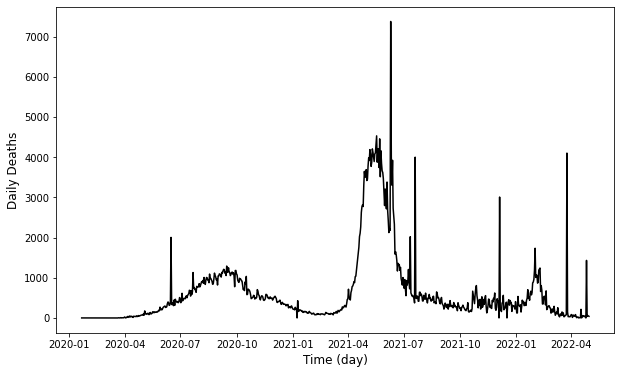

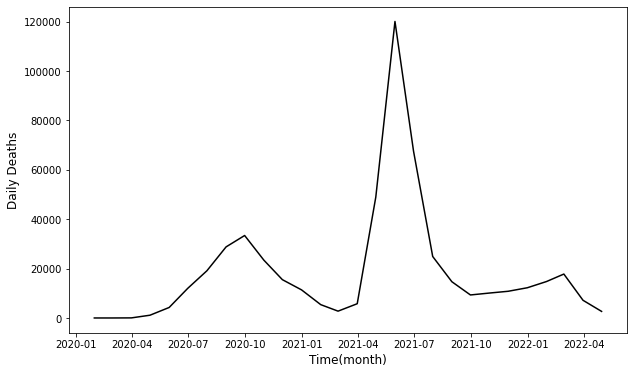

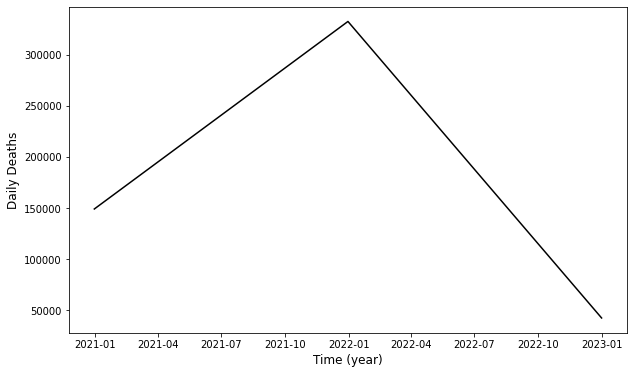

In [97]:
#analysing the data daily, monthly and yearly
dataset = daily_death.copy()
timeseries(daily_death.index, dataset['death'], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['death'], 
           'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['death'], 
           'Time (year)')

In [98]:
dataset

,death,month,year
date,,,
2020-01-22,0,1,2020
2020-01-23,0,1,2020
2020-01-24,0,1,2020
2020-01-25,0,1,2020
2020-01-26,0,1,2020
...,...,...,...
2022-04-26,1431,4,2022
2022-04-27,39,4,2022
2022-04-28,60,4,2022


In [99]:
# Split train data and test data
train_size = int(len(daily_death)*0.8)
#iloc is used to find a subset of the dataframe based on their index position
train_data = daily_death.iloc[:train_size]
test_data = daily_death.iloc[train_size:]

In [100]:
train_data

,death
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-11-11,501
2021-11-12,555
2021-11-13,285


In [101]:
len(train_data),len(test_data)

(664, 166)

In [102]:
##scale or normalize data as the data is too skewed
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [103]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)

Now

1). X_train - This includes your all independent variables,these will be used to train the model, also as we have specified the test_size = 0.2, this means 80% of observations from your complete data will be used to train/fit the model and rest 20% will be used to test the model.

2). X_test - This is remaining 20% portion of the independent variables from the data which will not be used in the training phase and will be used to make predictions to test the accuracy of the model.

3). y_train - This is your dependent variable which needs to be predicted by this model, this includes category labels against your independent variables, we need to specify our dependent variable while training/fitting the model.

4). y_test - This data has category labels for your test data, these labels will be used to test the accuracy between actual and predicted categories.

In [104]:
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (634, 30, 1)
y_train.shape:  (634, 1)
X_test.shape:  (136, 30, 1)
y_test.shape:  (136, 1)


In [105]:
# Create RNN model
def create_rnn(units):
    model = Sequential()
    # Input layer
    model.add(SimpleRNN (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(SimpleRNN(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_rnn = create_rnn(64)

In [106]:
# Create LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_lstm = create_lstm(64)

In [107]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True, activation='relu'), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units,activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation='relu'))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)

In [108]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [109]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history


In [110]:
history_rnn = fit_model(model_rnn)

Epoch 1/100
32/32 [==============================] - 5s 46ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 7/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0123 - val_loss: 0.0049
Epoch 8/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0167 - val_loss: 0.0075
Epoch 9/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0047 - val_loss: 0.0034

In [111]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
32/32 [==============================] - 8s 75ms/step - loss: 0.0151 - val_loss: 0.0046
Epoch 2/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 3/100
32/32 [==============================] - 2s 48ms/step - loss: 0.0071 - val_loss: 0.0035
Epoch 4/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0175 - val_loss: 0.0028
Epoch 5/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 6/100
32/32 [==============================] - 1s 46ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 7/100
32/32 [==============================] - 2s 47ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 8/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 9/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 10/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0045 - val_loss: 0.0035

In [112]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
32/32 [==============================] - 14s 117ms/step - loss: 0.0321 - val_loss: 0.0050
Epoch 2/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0164 - val_loss: 0.0030
Epoch 3/100
32/32 [==============================] - 2s 74ms/step - loss: 0.0092 - val_loss: 0.0023
Epoch 4/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 5/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0061 - val_loss: 0.0023
Epoch 6/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 7/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 8/100
32/32 [==============================] - 2s 70ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 10/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0037 - val_loss: 0.00

In [113]:
history_gru = fit_model(model_gru)

Epoch 1/100
32/32 [==============================] - 10s 79ms/step - loss: 0.0331 - val_loss: 0.0061
Epoch 2/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0331 - val_loss: 0.0057
Epoch 3/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0199 - val_loss: 0.0026
Epoch 4/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 5/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 6/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 8/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/100
32/32 [==============================] - 2s 54ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 10/100
32/32 [==============================] - 2s 53ms/step - loss: 0.0038 - val_loss: 0.004

In [114]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [115]:
def plot_loss (history1, model_name1,history2, model_name2,history3, model_name3,history4, model_name4):
    plt.figure(figsize = (10, 6))
    plt.plot(history1.history['loss'])
    #plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['loss'])
    #plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['loss'])
    #plt.plot(history3.history['val_loss'])
    plt.plot(history4.history['loss'])
    #plt.plot(history4.history['val_loss'])
    plt.title('Comparision of Train loss')
    plt.legend(['RNN', 'LSTM', 'Bi-LSTM', 'GRU'],loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.savefig("Comp_Train_loss.png")

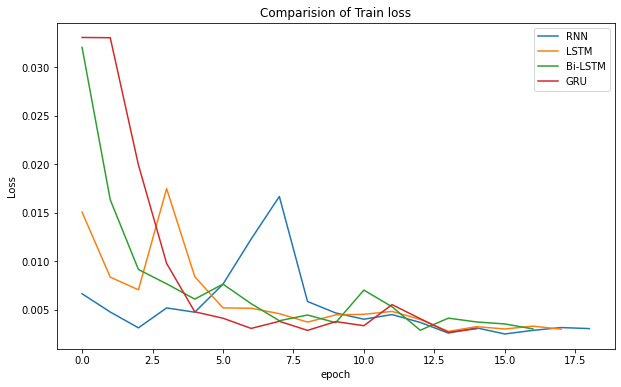

In [116]:
plot_loss (history_rnn, 'RNN',history_lstm, 'LSTM',history_bilstm, 'Bi-LSTM',history_gru, 'GRU')

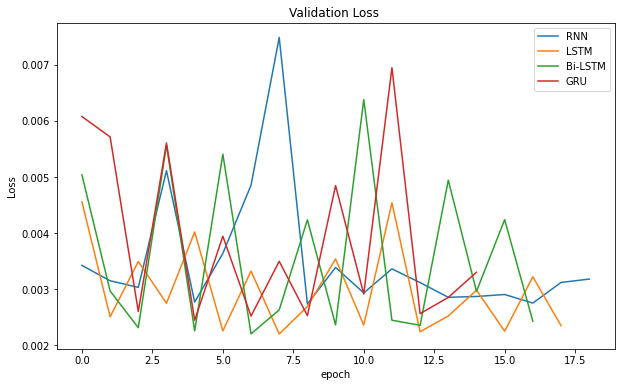

In [117]:
#plotting the validation loss
plt.figure(figsize = (10, 6))
plt.plot(history_rnn.history['val_loss'])
plt.plot(history_lstm.history['val_loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Validation Loss ' )
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['RNN', 'LSTM','Bi-LSTM','GRU'], loc='upper right')

In [118]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

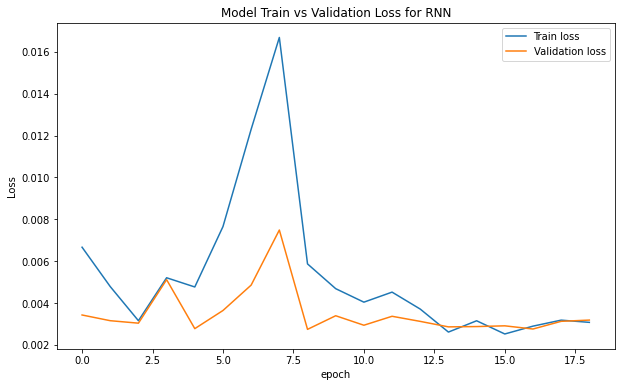

In [119]:
plot_loss(history_rnn,'RNN')

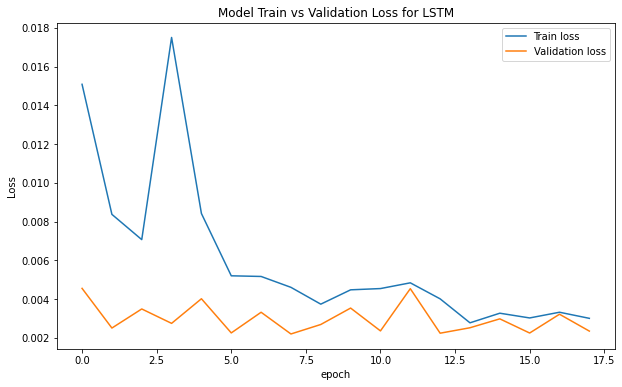

In [120]:
plot_loss (history_lstm, 'LSTM')

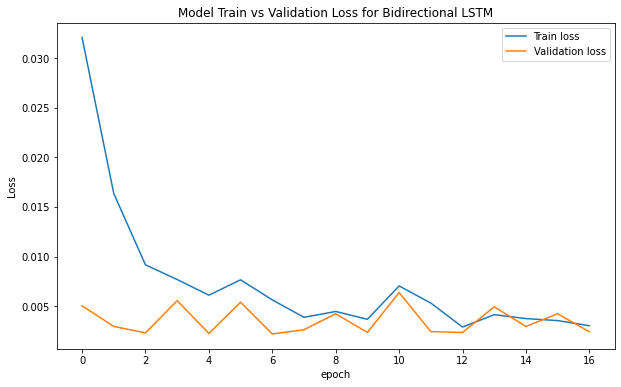

In [121]:
plot_loss (history_bilstm, 'Bidirectional LSTM')

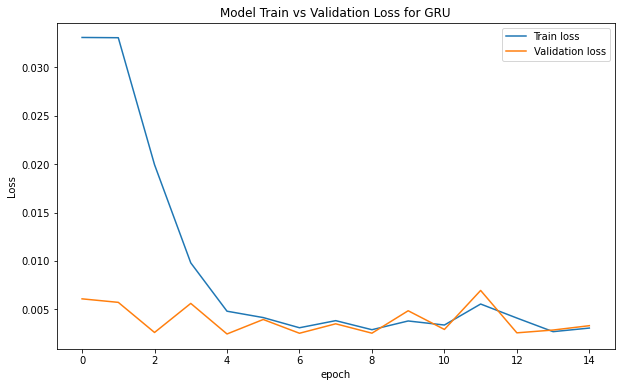

In [122]:
plot_loss (history_gru, 'GRU')

In [123]:
# Make modeling
def modeling(model):
    modeling = model.predict(X_train)
    modeling = scaler.inverse_transform(modeling)
    return modeling
modeling_rnn = modeling(model_rnn)
modeling_lstm = modeling(model_lstm)
modeling_bilstm = modeling(model_bilstm)
modeling_gru = modeling(model_gru)

20/20 [==============================] - 1s 17ms/step


In [124]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_rnn = prediction(model_rnn)
prediction_lstm = prediction(model_lstm)
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)

5/5 [==============================] - 0s 17ms/step


In [125]:
# Plot train data vs modeling
def plot_model(modeling, model_name, y_train):
    plt.figure(figsize=(10, 6))
    range_future = daily_death.index[:len(modeling)]
    plt.plot(range_future, np.array(y_train), 
             label='Train   data')
    plt.plot(range_future, 
             np.array(modeling),label='Modeling')
    plt.title('Train data vs modeling for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily Deaths')

Text(0, 0.5, 'Total Daily Deaths')

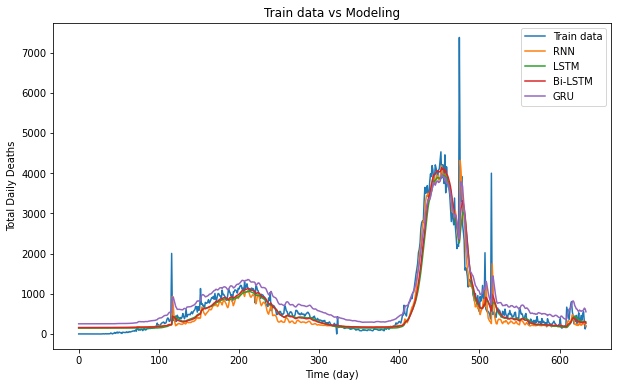

In [126]:
# Plot train data vs modeling
plt.figure(figsize=(10, 6))
range_future = len(modeling_rnn)
plt.plot(np.arange(range_future), np.array(y_train),label='Train data')
plt.plot(np.arange(range_future), np.array(modeling_rnn),label='RNN')
plt.plot(np.arange(range_future), np.array(modeling_lstm),label='LSTM')
plt.plot(np.arange(range_future), np.array(modeling_bilstm),label='Bi-LSTM')
plt.plot(np.arange(range_future), np.array(modeling_gru),label='GRU')
plt.title('Train data vs Modeling')
plt.legend(loc='upper right')
plt.xlabel('Time (day)')
plt.ylabel('Total Daily Deaths')

Text(0, 0.5, 'Total Daily Deaths')

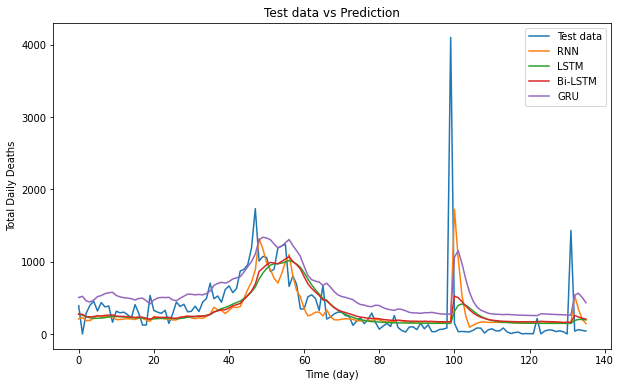

In [127]:
# Plot test data vs prediction
plt.figure(figsize=(10, 6))
range_future = len(prediction_rnn)
plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
plt.plot(np.arange(range_future), np.array(prediction_rnn),label='RNN')
plt.plot(np.arange(range_future), np.array(prediction_lstm),label='LSTM')
plt.plot(np.arange(range_future), np.array(prediction_bilstm),label='Bi-LSTM')
plt.plot(np.arange(range_future), np.array(prediction_gru),label='GRU')
plt.title('Test data vs Prediction')
plt.legend(loc='upper right')
plt.xlabel('Time (day)')
plt.ylabel('Total Daily Deaths')

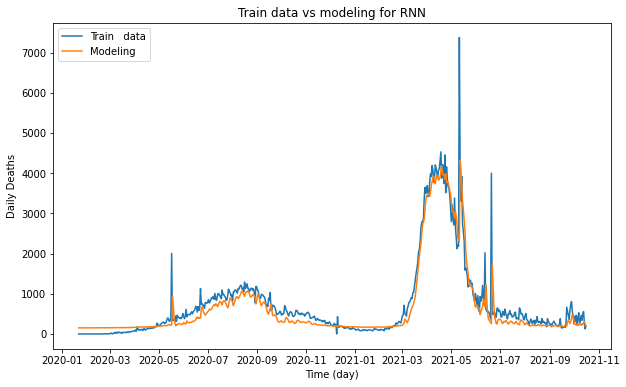

In [128]:
plot_model(modeling_rnn, 'RNN', y_train)

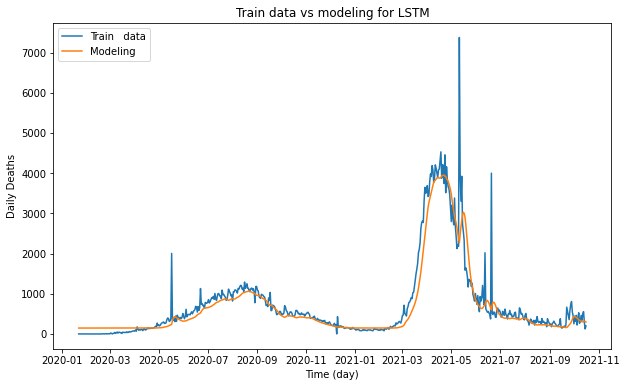

In [129]:
plot_model(modeling_lstm, 'LSTM', y_train)

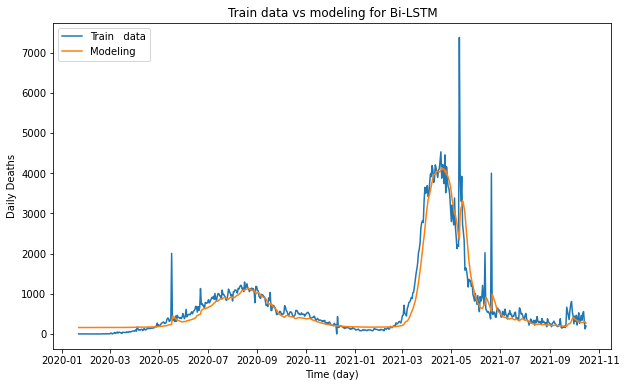

In [130]:
plot_model(modeling_bilstm, 'Bi-LSTM', y_train)

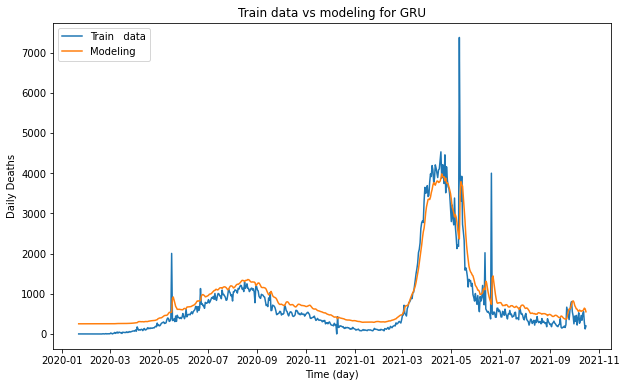

In [131]:
plot_model(modeling_gru, 'GRU', y_train)

In [132]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Death Cases')

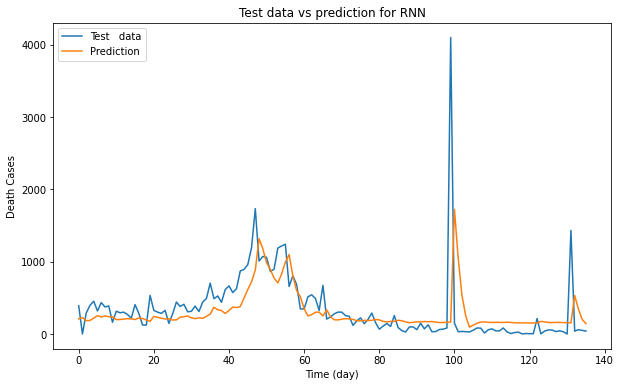

In [133]:
plot_future(prediction_rnn, 'RNN', y_test)

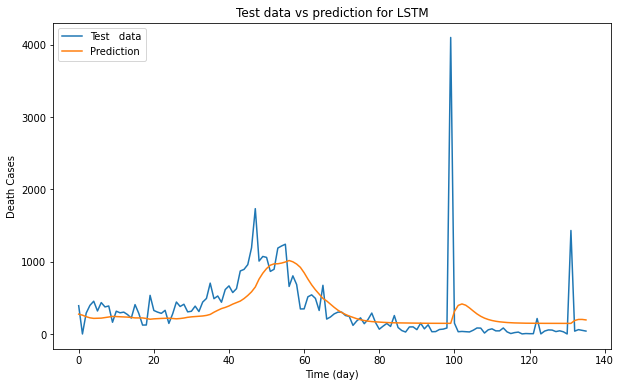

In [134]:
plot_future(prediction_lstm, 'LSTM', y_test)

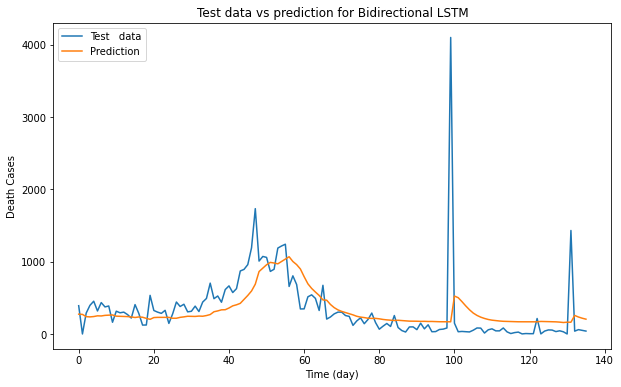

In [135]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

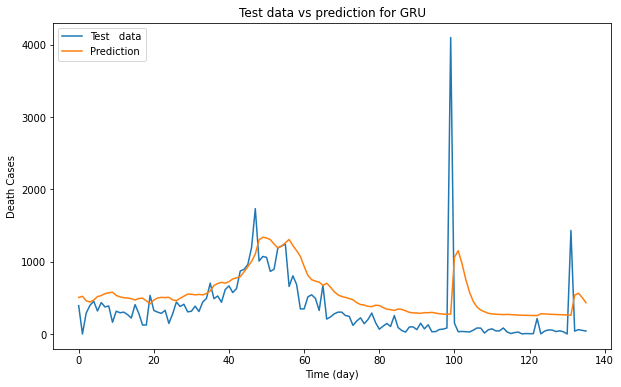

In [136]:
plot_future(prediction_gru, 'GRU', y_test)

In [137]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

def evaluate_prediction(predictions, actual, model_name):
  global mse, rmse, mae, mda, ev, mape
  errors = predictions - actual
  #m=(abs(predictions)+abs(actual))/2
  mse = mean_squared_error(actual,predictions)
  rmse = mean_squared_error(actual, predictions, squared = False)
  mae = mean_absolute_error(actual, predictions)
  mda = np.mean((np.sign(actual[1:] - actual[:-1])==np.sign(predictions[1:] - predictions[:-1])).astype(int))
  ev = explained_variance_score(actual, predictions)
  #mape = mean_absolute_percentage_error(actual, predictions)
  #smape= np.mean(errors/m)
  print(model_name + ':')
  print('Mean Absolute Error: {:.4f}'.format(mae))
  print('Mean Square Error: {:.4f}'.format(mse))
  print('Root Mean Square Error: {:.4f}'.format(rmse))
  print('Mean Directional Accuracy: {:.4f}'.format(mda))
  print('Explained Variance Score: {:.4f}'.format(ev))
  # the value when some element of the y_true is zero is arbitrarily high because of the division by epsilon
  #print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
  print('')

evaluate_prediction(prediction_rnn, y_test, 'Simple RNN')
E1=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
E2=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
E3=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_gru, y_test, 'GRU')
E4=[mae,mse,rmse,mda,ev]

Simple RNN:
Mean Absolute Error: 206.4077
Mean Square Error: 190813.2198
Root Mean Square Error: 436.8217
Mean Directional Accuracy: 0.3704
Explained Variance Score: 0.1306

LSTM:
Mean Absolute Error: 196.5570
Mean Square Error: 171261.9993
Root Mean Square Error: 413.8381
Mean Directional Accuracy: 0.4667
Explained Variance Score: 0.2163

Bidirectional LSTM:
Mean Absolute Error: 202.2630
Mean Square Error: 170905.0778
Root Mean Square Error: 413.4067
Mean Directional Accuracy: 0.4000
Explained Variance Score: 0.2143

GRU:
Mean Absolute Error: 293.0867
Mean Square Error: 215640.7640
Root Mean Square Error: 464.3714
Mean Directional Accuracy: 0.3778
Explained Variance Score: 0.1948



In [138]:
data_dict={'Model': ['RNN', 'LSTM', 'BiLSTM', 'GRU'],
             'mae': [E1[0],E2[0],E3[0],E4[0]],
             'mse': [E1[1],E2[1],E3[1],E4[1]],
           'rmse':[E1[2],E2[2],E3[2],E4[2]],
           'mda':[E1[3],E2[3],E3[3],E4[3]],
           'ev':[E1[4],E2[4],E3[4],E4[4]]}
           #'mape':[E1[5],E2[5],E3[5],E4[5]]}

a=pd.DataFrame(data=data_dict)
a

,Model,mae,mse,rmse,mda,ev
0,RNN,206.407700,190813.219776,436.821725,0.370370,0.130571
1,LSTM,196.557000,171261.999295,413.838132,0.466667,0.216261
2,BiLSTM,202.263019,170905.077756,413.406674,0.400000,0.214262
3,GRU,293.086665,215640.764017,464.371364,0.377778,0.194799


In [139]:
#creating dataset for forecasting
def create_dataset (X, look_back, n):
    Xs = []
    for i in range(n): #put the number of days to predict
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

In [140]:
# function for forecasting new data
def forecasted(model,model_name, new_data):
    forecasted = model.predict(new_data)
    forecasted = scaler.inverse_transform(forecasted)
    print("Forecasted for",model_name,":")
    print(forecasted)
    return forecasted

In [141]:
#Forecasting 1 day death
new_data= create_dataset(test_scaled,30,1)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (1, 30, 1)
1/1 [==============================] - 0s 50ms/step
Forecasted for RNN :
[[208.6164]]
1/1 [==============================] - 0s 66ms/step
Forecasted for LSTM :
[[273.99332]]
1/1 [==============================] - 0s 51ms/step
Forecasted for Bi-LSTM :
[[273.6862]]
1/1 [==============================] - 0s 51ms/step
Forecasted for GRU :
[[504.73065]]


In [142]:
#Forecasting 3 day deaths
new_data= create_dataset(test_scaled,30,3)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN',new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM',new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM',new_data)
forecasted_gru = forecasted(model_gru,'GRU',new_data)

X_30.shape:  (3, 30, 1)
1/1 [==============================] - 0s 51ms/step
Forecasted for RNN :
[[208.61641]
 [227.65366]
 [184.19902]]
1/1 [==============================] - 0s 59ms/step
Forecasted for LSTM :
[[273.9933 ]
 [260.0838 ]
 [239.14218]]
1/1 [==============================] - 0s 51ms/step
Forecasted for Bi-LSTM :
[[273.68616]
 [270.74796]
 [239.71024]]
1/1 [==============================] - 0s 50ms/step
Forecasted for GRU :
[[504.73068]
 [520.74725]
 [458.04123]]


In [143]:
#Forecasting 7 day deaths
new_data= create_dataset(test_scaled,30, 7)
print('new_data.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN',new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM',new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM',new_data)
forecasted_gru = forecasted(model_gru,'GRU',new_data)

new_data.shape:  (7, 30, 1)
1/1 [==============================] - 0s 51ms/step
Forecasted for RNN :
[[208.61641]
 [227.65366]
 [184.19902]
 [186.9723 ]
 [218.63347]
 [253.80325]
 [234.5015 ]]
1/1 [==============================] - 0s 60ms/step
Forecasted for LSTM :
[[273.9933 ]
 [260.0838 ]
 [239.14218]
 [223.18806]
 [215.70032]
 [217.39644]
 [219.0506 ]]
1/1 [==============================] - 0s 58ms/step
Forecasted for Bi-LSTM :
[[273.68616]
 [270.74796]
 [239.71024]
 [236.11774]
 [240.95154]
 [251.0036 ]
 [249.07129]]
1/1 [==============================] - 0s 51ms/step
Forecasted for GRU :
[[504.73068]
 [520.74725]
 [458.04123]
 [442.50684]
 [468.85602]
 [516.40265]
 [531.21875]]


In [144]:
# Plot history and future
def plot_multi_step(history, prediction1, prediction2, prediction3, prediction4, n):
    
    plt.figure(figsize=(15, 6))
    
    range_history = daily_death.index[len(daily_death)-len(history):]
    l = []
    for x in range(1,n+1):
        l.append((daily_death.index[-1] + timedelta(days=x)))
    range_future = l
    plt.plot(range_history, np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1), label='Forecasted for SimpleRNN')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for LSTM')
    plt.plot(range_future, np.array(prediction3), label='Forecasted for BiLSTM')
    plt.plot(range_future, np.array(prediction4), label='Forecasted for GRU')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Daily Deaths')
    plt.title('Predicted daily death for the next {} days'.format(n))      

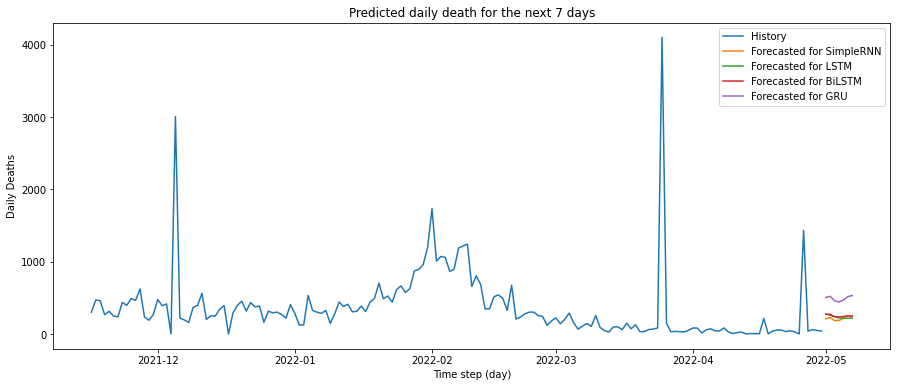

In [145]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,7)

In [146]:
#Forecasting 15 day deaths
new_data= create_dataset(test_scaled,30,15)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (15, 30, 1)
1/1 [==============================] - 0s 50ms/step
Forecasted for RNN :
[[208.61641]
 [227.65366]
 [184.19902]
 [186.9723 ]
 [218.63347]
 [253.80325]
 [234.5015 ]
 [249.04938]
 [238.58194]
 [237.2448 ]
 [198.79094]
 [199.73466]
 [206.4255 ]
 [211.05067]
 [208.20265]]
1/1 [==============================] - 0s 59ms/step
Forecasted for LSTM :
[[273.9933 ]
 [260.0838 ]
 [239.14218]
 [223.18806]
 [215.70032]
 [217.39644]
 [219.0506 ]
 [226.43462]
 [234.46251]
 [243.09444]
 [240.87102]
 [238.79044]
 [236.07004]
 [233.02802]
 [228.75667]]
1/1 [==============================] - 0s 59ms/step
Forecasted for Bi-LSTM :
[[273.68616]
 [270.74796]
 [239.71024]
 [236.11774]
 [240.95154]
 [251.0036 ]
 [249.07129]
 [257.25677]
 [259.85364]
 [263.1259 ]
 [246.27092]
 [244.40327]
 [242.0292 ]
 [240.29219]
 [235.79091]]
1/1 [==============================] - 0s 52ms/step
Forecasted for GRU :
[[504.73068]
 [520.74725]
 [458.04123]
 [442.50684]
 [468.85602]
 [516.40265]
 [531.21875]

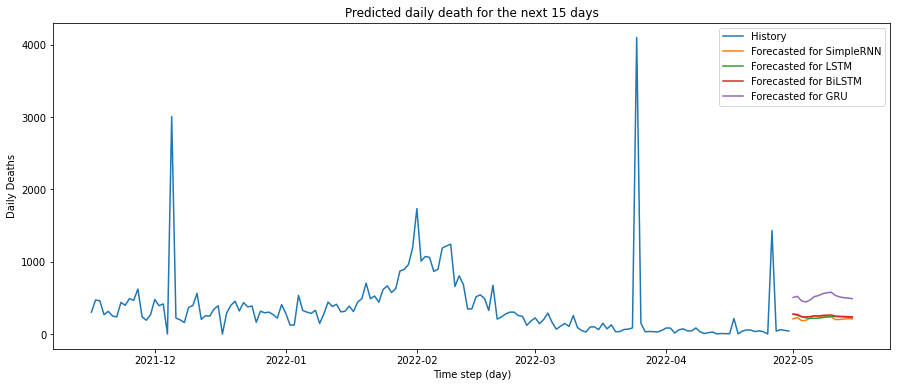

In [147]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,15)

In [148]:
#Forecasting 15 day deaths
new_data= create_dataset(test_scaled,30,30)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (30, 30, 1)
1/1 [==============================] - 0s 49ms/step
Forecasted for RNN :
[[208.61641]
 [227.65366]
 [184.19902]
 [186.9723 ]
 [218.63347]
 [253.80325]
 [234.5015 ]
 [249.04938]
 [238.58194]
 [237.2448 ]
 [198.79094]
 [199.73466]
 [206.4255 ]
 [211.05067]
 [208.20265]
 [200.09329]
 [221.3988 ]
 [214.39139]
 [192.72192]
 [174.413  ]
 [242.00919]
 [230.77237]
 [219.4514 ]
 [206.84235]
 [210.4805 ]
 [192.77724]
 [194.92088]
 [231.96384]
 [239.0848 ]
 [248.2298 ]]
1/1 [==============================] - 0s 61ms/step
Forecasted for LSTM :
[[273.9933 ]
 [260.0838 ]
 [239.14218]
 [223.18806]
 [215.70032]
 [217.39644]
 [219.0506 ]
 [226.43462]
 [234.46251]
 [243.09444]
 [240.87102]
 [238.79044]
 [236.07004]
 [233.02802]
 [228.75667]
 [222.04456]
 [222.47313]
 [221.87317]
 [214.49933]
 [203.8773 ]
 [209.14252]
 [212.45251]
 [215.00514]
 [216.13333]
 [218.38686]
 [213.47354]
 [209.65062]
 [213.68309]
 [220.48488]
 [230.42833]]
1/1 [==============================] - 0s 75ms

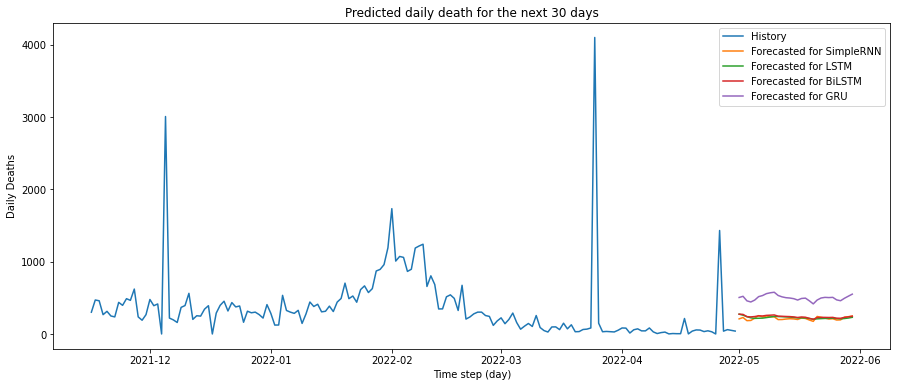

In [149]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,30)